In [1]:
%matplotlib inline
# !pip install pennylane
import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1727294684.8943086
Wed Sep 25 13:04:44 2024


In [42]:
%pip install PennyLane-Lightning-GPU

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /global/common/software/nersc9/pytorch/2.3.1/lib/python3.11/site-packages/torchvision-0.18.0a0+6043bc2-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 9.8 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pennylane import broadcast
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_moons


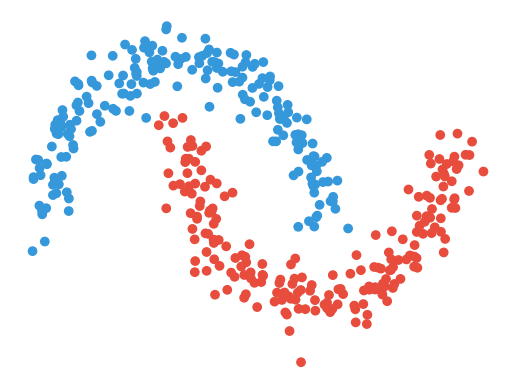

In [2]:

# Set random seeds
torch.manual_seed(149)
np.random.seed(149)

X, y = make_moons(n_samples=400, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((400, 2)), 1, y_, 1)

# Adjusted color scheme for better contrast
c = ["#3498db" if y_ == 0 else "#e74c3c" for y_ in y]  # New colors for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()


In [3]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

In [4]:
# this example only has one layer

import pennylane as qml
import numpy as np

n_qubits = 10
n_layers = 1  
dev = qml.device("lightning.qubit", wires=n_qubits)

# Define the Hadamard layer
def H_layer(n_qubits):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

# Define a custom function to add arbitrary rotations
def custom_rot_layer(weights, wires):
    # Apply Rot (arbitrary rotation) to each qubit individually
    for i, wire in enumerate(wires):
        phi, theta, omega = weights[i]
        qml.Rot(phi, theta, omega, wires=wire)

# Define a custom function for entanglement
def entangling_layer(wires, measured_1, measured_2):
    for j in range(len(wires) - 1):
        # Apply CNOT unconditionally between adjacent qubits
        qml.CNOT(wires=[wires[j], wires[j + 1]])

        # Conditionally apply CRZ if measured_1 is 1 (control qubit on qubit 1)
        qml.cond(measured_1, qml.CRZ)(np.pi / 2, wires=[wires[j], wires[j + 1]])

        # Conditionally apply a controlled-RY gate if measured_2 is 1 (control qubit on qubit 2)
        qml.cond(measured_2, qml.CRY)(np.pi / 4, wires=[wires[j], wires[j + 1]])

@qml.qnode(dev)
def qnode(inputs, weights, x, z):
    H_layer(n_qubits)

    for i in range(n_layers):
        # Embedding with alternating rotation axes
        if i % 2 == 0:
            qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        else:
            qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Z')
        
        # Measure qubits 1 and 2 for conditional execution
        measured_1 = qml.measure(1)
        measured_2 = qml.measure(2)

        # Add an entangling layer with partial conditional gates
        entangling_layer(range(n_qubits), measured_1, measured_2)
        
        # Apply a custom layer of arbitrary rotations using qml.Rot
        custom_rot_layer(weights[i], range(n_qubits))

    # Apply a final set of Rot gates to close the circuit
    custom_rot_layer(weights[-1], range(n_qubits))
    
    # Apply a controlled CRZ rotation based on the measurement of qubit 2
    qml.cond(measured_2, qml.CRZ)(z, wires=(3, 0))

    # Final Hadamard layer
    H_layer(n_qubits)

    # Return PauliZ expectation values and the measurement probabilities for qubit 2
    return [qml.expval(qml.PauliZ(wires=i/ for i in range(n_qubits)], qml.probs(op=measured_2)


In [ ]:
core_node_cut = core_node[:-23]

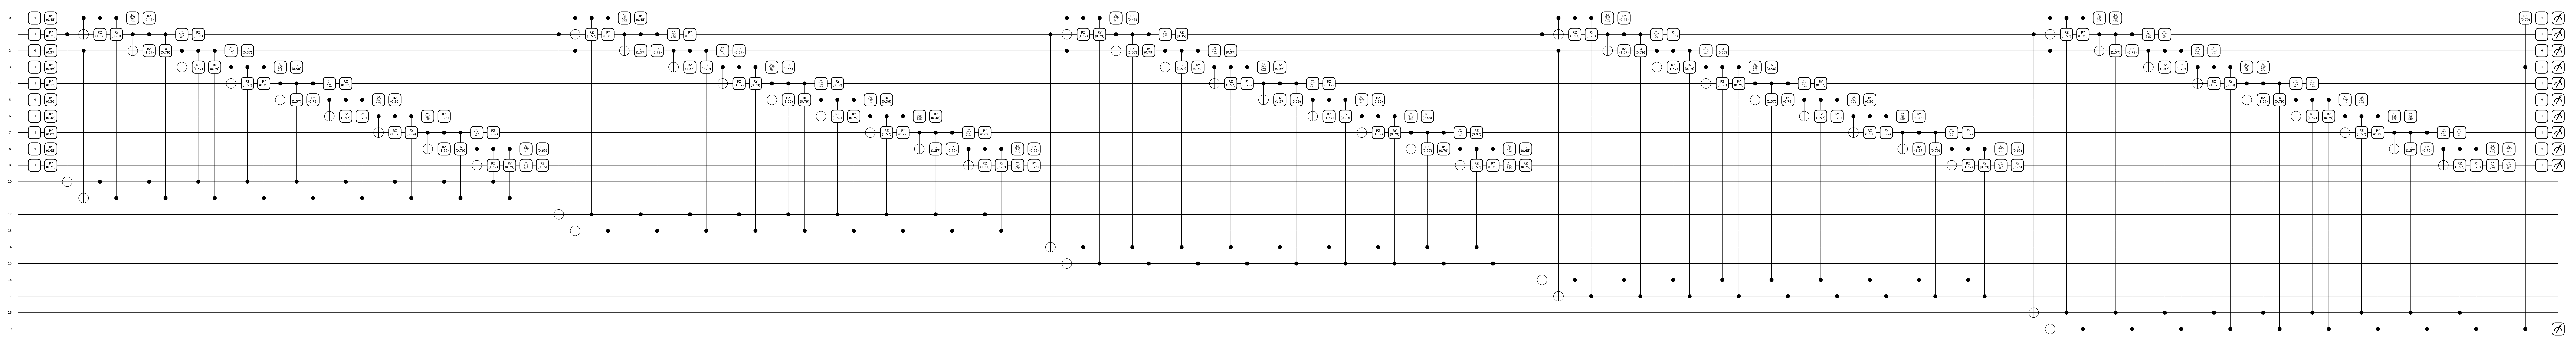

In [8]:
# Example inputs and weights
inputs = np.random.rand(n_qubits)
weights = np.random.rand(n_layers + 1, n_qubits, 3)  # +1 for the final Rot layer
x = np.pi / 6  # Example parameter for RX
z = np.pi / 4  # Example parameter for CRZ

fig, ax = qml.draw_mpl(qnode, show_all_wires=True, decimals=2, level="device")(inputs,weights,x,z)
fig.show()

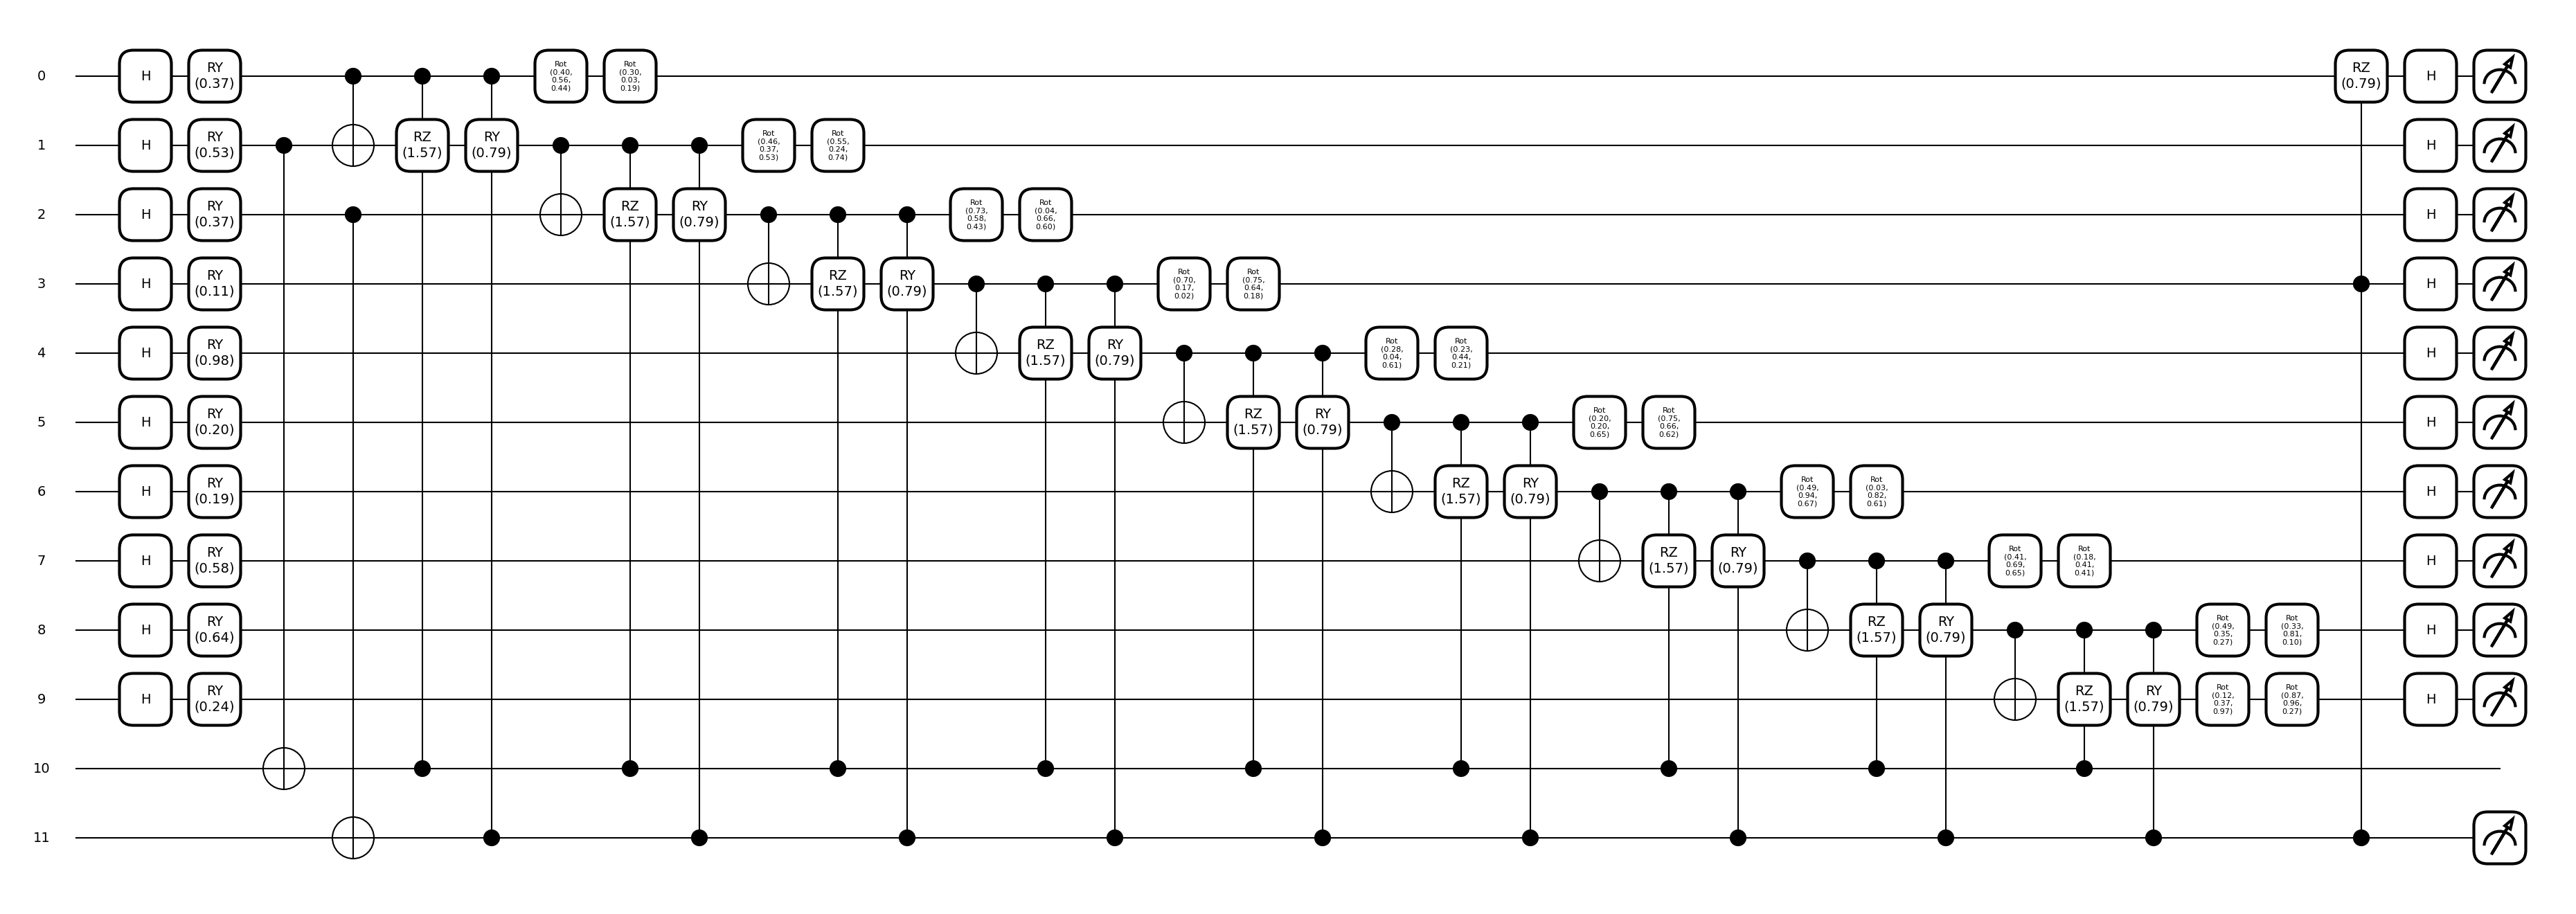

In [69]:
# Example inputs and weights
inputs = np.random.rand(n_qubits)
weights = np.random.rand(n_layers + 1, n_qubits, 3)  # +1 for the final Rot layer
x = np.pi / 6  # Example parameter for RX
z = np.pi / 4  # Example parameter for CRZ

fig, ax = qml.draw_mpl(qnode, show_all_wires=True, decimals=2, level="device")(inputs,weights,x,z)
fig.show()

In [70]:
fig.savefig("structure2.png")

In [10]:
print(qml.draw(qnode, expansion_strategy="device")(inputs,weights,x,z))

 0: ──H──RY(0.45)────╭●─╭●────────╭●─────────Rot(0.74,0.88,0.61)──RZ(0.45)──────────
 1: ──H──RY(0.35)─╭●─╰X─├RZ(1.57)─├RY(0.79)─╭●───────────────────╭●────────╭●───────
 2: ──H──RY(0.37)─│──╭●─│─────────│─────────╰X───────────────────├RZ(1.57)─├RY(0.79)
 3: ──H──RY(0.56)─│──│──│─────────│──────────────────────────────│─────────│────────
 4: ──H──RY(0.12)─│──│──│─────────│──────────────────────────────│─────────│────────
 5: ──H──RY(0.36)─│──│──│─────────│──────────────────────────────│─────────│────────
 6: ──H──RY(0.48)─│──│──│─────────│──────────────────────────────│─────────│────────
 7: ──H──RY(0.02)─│──│──│─────────│──────────────────────────────│─────────│────────
 8: ──H──RY(0.65)─│──│──│─────────│──────────────────────────────│─────────│────────
 9: ──H──RY(0.75)─│──│──│─────────│──────────────────────────────│─────────│────────
10: ──────────────╰X─│──╰●────────│──────────────────────────────╰●────────│────────
11: ─────────────────╰X───────────╰●─────────────────────────────

In [11]:
loss_func = torch.nn.L1Loss()

In [89]:
n_layers = 5
weight_shapes = {"weights": (n_layers + 1, n_qubits)}
weight_shapes


{'weights': (6, 10)}

In [90]:
qnode

<QNode: device='<lightning.qubit device (wires=10) at 0x7f7dfd6ad350>', interface='auto', diff_method='best'>

In [98]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 320)
        
        # Define a list of quantum layers using ModuleList
        self.qlayers = torch.nn.ModuleList(
            [qml.qnn.TorchLayer(qnode, weight_shapes) for _ in range(320)]
        )
        
        self.clayer_2 = torch.nn.Linear(320, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        # Split input into 320 chunks
        x_split = torch.split(x, 1, dim=1)
        
        # Apply each quantum layer to each chunk
        x_processed = [layer(x_i) for layer, x_i in zip(self.qlayers, x_split)]
        
        # Concatenate the processed outputs
        x = torch.cat(x_processed, dim=1)
        
        x = self.clayer_2(x)
        return self.softmax(x)

model = HybridModel()


In [99]:
from sklearn.model_selection import train_test_split

In [100]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Prepare data
X = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

batch_size = 5
epochs = 40

# Split and preprocess the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=149)
X_train, X_test = map(lambda t: torch.tensor(t, requires_grad=True).float(), [X_train, X_test])

def one_hot_encode(y, num_classes=2):
    y = torch.unsqueeze(torch.tensor(y), 1)
    return torch.scatter(torch.zeros((len(y), num_classes)), 1, y, 1).float()

y_train_hot = one_hot_encode(y_train)
y_test_hot = one_hot_encode(y_test)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train_hot), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(TensorDataset(X_test, y_test_hot), batch_size=batch_size, shuffle=True, drop_last=True)

# Model optimizer and loss tracking
opt = torch.optim.SGD(model.parameters(), lr=0.52)
train_acc_history, test_acc_history = [], []

# Training loop
for epoch in range(epochs):
    train_running_loss = 0
    
    # Training phase
    model.train()
    for xs, ys in train_loader:
        opt.zero_grad()
        loss = loss_func(model(xs), ys)
        loss.backward()
        opt.step()
        train_running_loss += loss.item()
    
    print(f"Train - Epoch {epoch + 1}: Loss: {train_running_loss / len(train_loader):.4f}")

    # Calculate accuracy function
    def calculate_accuracy(X, y):
        with torch.no_grad():
            y_pred = model(X)
            preds = torch.argmax(y_pred, axis=1).detach().numpy()
            return (preds == y).mean()

    # Track train and test accuracy
    train_accuracy = calculate_accuracy(X_train, y_train)
    test_accuracy = calculate_accuracy(X_test, y_test)

    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    
    train_acc_history.append(train_accuracy)
    test_acc_history.append(test_accuracy)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x3200 and 320x2)

In [100]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Prepare data
X = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

batch_size = 5
epochs = 40

# Split and preprocess the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=149)
X_train, X_test = map(lambda t: torch.tensor(t, requires_grad=True).float(), [X_train, X_test])

def one_hot_encode(y, num_classes=2):
    y = torch.unsqueeze(torch.tensor(y), 1)
    return torch.scatter(torch.zeros((len(y), num_classes)), 1, y, 1).float()

y_train_hot = one_hot_encode(y_train)
y_test_hot = one_hot_encode(y_test)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train_hot), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(TensorDataset(X_test, y_test_hot), batch_size=batch_size, shuffle=True, drop_last=True)

# Model optimizer and loss tracking
opt = torch.optim.SGD(model.parameters(), lr=0.52)
train_acc_history, test_acc_history = [], []

# Training loop
for epoch in range(epochs):
    train_running_loss = 0
    
    # Training phase
    model.train()
    for xs, ys in train_loader:
        opt.zero_grad()
        loss = loss_func(model(xs), ys)
        loss.backward()
        opt.step()
        train_running_loss += loss.item()
    
    print(f"Train - Epoch {epoch + 1}: Loss: {train_running_loss / len(train_loader):.4f}")

    # Calculate accuracy function
    def calculate_accuracy(X, y):
        with torch.no_grad():
            y_pred = model(X)
            preds = torch.argmax(y_pred, axis=1).detach().numpy()
            return (preds == y).mean()

    # Track train and test accuracy
    train_accuracy = calculate_accuracy(X_train, y_train)
    test_accuracy = calculate_accuracy(X_test, y_test)

    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    
    train_acc_history.append(train_accuracy)
    test_acc_history.append(test_accuracy)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x3200 and 320x2)

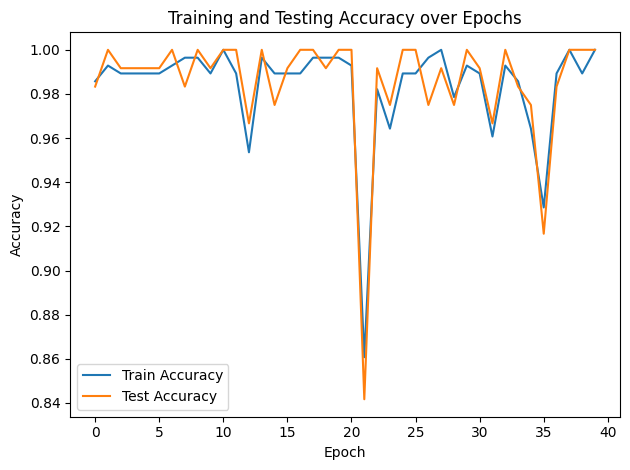

In [24]:
# Plotting the training and testing accuracies
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy over Epochs')
plt.tight_layout()
plt.show()

In [41]:
# Generate mesh grid covering the feature space
# Creating a meshgrid
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

In [42]:
mesh_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

In [37]:
# Predict class for each point in the grid
Z = predictions_train.reshape(xx.shape)

In [9]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1708813854.662059
Sat Feb 24 15:30:54 2024
